In [1]:
import os
import pandas as pd, numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
VER = 1

In [2]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

USE_WAVELET = None

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    # Parameters for STFT
    sr = 200  # Sample rate
    n_fft = 1024  # Number of FFT points
    max_bin = int(20 * n_fft / sr)  # Limit for frequency bins (20 Hz)

    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)
            
            # STFT SPECTROGRAM (From the raw EEG data, limiting frequency to 0-20Hz)
            D = librosa.stft(y=x, n_fft=n_fft, hop_length=len(x)//256, win_length=128)
            width = (D.shape[1]//32)*32
            spectrogram = np.abs(D)[:max_bin + 1, :]
            spectrogram_db = librosa.power_to_db(spectrogram)
            
            freqs = np.linspace(0, 20, spectrogram_db.shape[0])
            target_freqs = np.linspace(0, 20, 128)
            
            rescaled_spectrogram = np.zeros((128, spectrogram_db.shape[1]))
            for i in range(spectrogram_db.shape[1]):
                rescaled_spectrogram[:, i] = np.interp(target_freqs, freqs, spectrogram_db[:, i])
            if (rescaled_spectrogram.shape != (128, 257)):
                print("rescaled_spectrogram: ", rescaled_spectrogram.shape)
            # STANDARDIZE TO -1 TO 1    
            rescaled_spectrogram = normalize(rescaled_spectrogram)

            img[:,:,k] += rescaled_spectrogram[:, :width]
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

def normalize(arr):
    """Normalizes numpy arrays within the range -1 and 1"""
    if (np.min(arr) == np.max(arr)):
        print("happens")
        normalized_arr = np.zeros(arr.shape)
    else:
        normalized_arr = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    return normalized_arr

In [3]:
# check the reading of one parquet for understanding

BASE_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'

df = pd.DataFrame({'path': glob(BASE_PATH + '**/*.parquet')})
df['test_type'] = df['path'].str.split('/').str.get(-2).str.split('_').str.get(-1)
df['id'] = df['path'].str.split('/').str.get(-1).str.split('.').str.get(0)

df_eeg = pd.read_parquet(BASE_PATH + 'train_eegs/1000913311.parquet')
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [4]:
# Determine the number of channels
# Assuming each row is a time point and each column is a channel
n_channels = df_eeg.shape[1]
n_channels

20

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>LOAD TRAIN DATA</b></div>

In [5]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [6]:
# Creating a Unique EEG Segment per eeg_id:
# The code groups (groupby) the EEG data (df) by eeg_id. Each eeg_id represents a different EEG recording.
# It then picks the first spectrogram_id and the earliest (min) spectrogram_label_offset_seconds for each eeg_id. This helps in identifying the starting point of each EEG segment.
# The resulting DataFrame train has columns spec_id (first spectrogram_id) and min (earliest spectrogram_label_offset_seconds).
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']


# Finding the Latest Point in Each EEG Segment:
# The code again groups the data by eeg_id and finds the latest (max) spectrogram_label_offset_seconds for each segment.
# This max value is added to the train DataFrame, representing the end point of each EEG segment.
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp


tmp = df.groupby('eeg_id')[['patient_id']].agg('first') # The code adds the patient_id for each eeg_id to the train DataFrame. This links each EEG segment to a specific patient.
train['patient_id'] = tmp


tmp = df.groupby('eeg_id')[TARGETS].agg('sum') # The code sums up the target variable counts (like votes for seizure, LPD, etc.) for each eeg_id.
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values # It then normalizes these counts so that they sum up to 1. This step converts the counts into probabilities, which is a common practice in classification tasks.
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first') # For each eeg_id, the code includes the expert_consensus on the EEG segment's classification.
train['target'] = tmp

train = train.reset_index() # This makes eeg_id a regular column, making the DataFrame easier to work with.
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>FEATURE ENGINEERING</b></div>



In [7]:
READ_SPEC_FILES = False # If READ_SPEC_FILES is False, the code reads the combined file instead of individual files.
FEATURE_ENGINEER = True
READ_EEG_SPEC_FILES = False

In [8]:
import os
directory_path = '/kaggle/input/stft-spectrograms-from-eeg/'
with os.scandir(directory_path) as entries:
    for entry in entries:
        full_path = os.path.join(directory_path, entry.name)
        print(full_path)


/kaggle/input/stft-spectrograms-from-eeg/__results__.html
/kaggle/input/stft-spectrograms-from-eeg/eeg_specs.npy
/kaggle/input/stft-spectrograms-from-eeg/__notebook__.ipynb
/kaggle/input/stft-spectrograms-from-eeg/__results___files
/kaggle/input/stft-spectrograms-from-eeg/EEG_Spectrograms
/kaggle/input/stft-spectrograms-from-eeg/__output__.json
/kaggle/input/stft-spectrograms-from-eeg/custom.css


In [9]:
%%time
# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load("/kaggle/input/stft-spectrograms-from-eeg/eeg_specs.npy",allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 8.17 s, sys: 17.3 s, total: 25.5 s
Wall time: 1min 29s


In [10]:
# %%time
# # READ ALL EEG SPECTROGRAMS
# if READ_EEG_SPEC_FILES:
#     all_eegs = {}
#     for i,e in enumerate(train.eeg_id.values):
#         if i%100==0: print(i,', ',end='')
#         x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
#         all_eegs[e] = x
# else:
#     all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()

print('original shape: ', spectrograms[1000913311].shape)

for i, key in enumerate(spectrograms):
    layer0 = spectrograms[key][:,:,0]
    layer1 = spectrograms[key][:,:,1]
    layer2 = spectrograms[key][:,:,2]
    layer3 = spectrograms[key][:,:,3]
    
    spectrograms[key] = np.vstack([layer0, layer1, layer2, layer3])

print('new shape: ', spectrograms[1000913311].shape)


original shape:  (128, 256, 4)
new shape:  (512, 256)


In [11]:
%time
# ENGINEER FEATURES
import warnings
# 20 (~21) sec windows optimal - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9739775/
# ~90 sec windows good - https://onelab-eg.com/wp-content/uploads/2019/05/MOCAST_2019_paper_37.pdf
warnings.filterwarnings('ignore')

SPEC_COLS = spectrograms[1000913311].shape[0]

FEATURES = [f'{c}_mean_50s' for c in range(SPEC_COLS)]
FEATURES += [f'{c}_mean_20s' for c in range(SPEC_COLS)]

print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

# A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# For each row in train, the code calculates the mean and minimum values within the specified 50 second and 20-second windows.
# These calculated values are then stored in the data matrix.
# Finally, the matrix is added to the train DataFrame as new columns.

if FEATURE_ENGINEER:
    data = np.zeros((len(train),len(FEATURES)))
    for k in range(len(train)):
        if k%100==0: 
            print(k,', ',end='')
            
        
        row = train.iloc[k]

        # each offset is the start of (potentially overlapping) 50s subsample of a
        # spectogram / eeg pair with unique label row. 
        # e.g. row['min'] -> row['min'] + 10 min is a subsample of EEG that has some annotated portion with labels in the row, same with row['max'] + 50s
        # since test set has no overlapping subsamples, we just get 1 set of features
        # per unique EEG_id
        # we take the midpoint of the largest and smallest offset for that EEG_ID
        # thereby centering the 50s window within all the subsamples of the EEG
        # since time in the spectogram rows is t=2,4,6,... (multiples of two)
        # we divide the midpoint by 2 to get the right start row 'r'.
        # then logically r+300 is end of 300*2 = 600 sec. and 20sec window is centered too.
        

        # 50 SECOND WINDOW FEATURES (MEANS and MINS) - Just 1 window in middle of spectogram        
        x = np.nanmean(spectrograms[row.eeg_id],axis=1)
        data[k,:512] = x
        
        # 20 SECOND WINDOW FEATURES (MEANS and MINS) - Just 1 window in middle of spectogram
        # if 0-256 is 50s, then (77,179) is the central 20 second window.
        x = np.nanmean(spectrograms[row.eeg_id][:,77:179],axis=1)
        data[k,512:1024] = x
 
    train[FEATURES] = data
else:
    train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')
print()
print('New train shape:',train.shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
We are creating 1024 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 

In [12]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,502_mean_20s,503_mean_20s,504_mean_20s,505_mean_20s,506_mean_20s,507_mean_20s,508_mean_20s,509_mean_20s,510_mean_20s,511_mean_20s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,-0.179047,-0.180994,-0.183227,-0.185488,-0.188210,-0.191139,-0.194391,-0.197919,-0.201329,-0.203864
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,-0.153586,-0.157685,-0.160728,-0.161861,-0.162120,-0.162078,-0.161801,-0.162611,-0.164648,-0.166727
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,-0.168216,-0.171333,-0.175511,-0.180329,-0.183165,-0.187308,-0.190705,-0.192443,-0.193323,-0.195981
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,-0.069542,-0.075132,-0.080227,-0.084596,-0.088764,-0.091552,-0.095275,-0.100152,-0.105485,-0.109637
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,-0.157180,-0.158298,-0.159120,-0.160744,-0.162991,-0.164210,-0.165967,-0.166920,-0.167118,-0.168210


In [13]:
from sklearn.preprocessing import StandardScaler

# Columns to be excluded from scaling
excluded_columns = ['eeg_id', 'spec_id', 'min', 'max', 'patient_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote','target']

# Save the columns to be excluded
excluded_data = train[excluded_columns]

# DataFrame with only the columns to be scaled
features = train.drop(columns=excluded_columns)

# Initialize the StandardScaler
train_scaler = StandardScaler()

# Fit the scaler to the features and transform them
features_scaled = train_scaler.fit_transform(features)

# Create a DataFrame from the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Concatenate the scaled features with the excluded columns
train_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)
# train_scaled_df.to_csv("/kaggle/working/")
train_scaled_df 


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,502_mean_20s,503_mean_20s,504_mean_20s,505_mean_20s,506_mean_20s,507_mean_20s,508_mean_20s,509_mean_20s,510_mean_20s,511_mean_20s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,-0.870521,-0.866864,-0.867080,-0.869694,-0.874683,-0.881158,-0.889589,-0.899659,-0.908789,-0.912056
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,-0.681896,-0.697291,-0.706181,-0.703382,-0.693595,-0.681815,-0.668300,-0.661937,-0.663478,-0.664887
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,-0.790277,-0.796580,-0.811897,-0.833379,-0.839663,-0.854883,-0.864555,-0.862788,-0.855249,-0.859592
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,-0.059280,-0.096712,-0.130513,-0.159520,-0.184439,-0.198030,-0.216582,-0.241425,-0.267807,-0.284922
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,-0.708523,-0.701749,-0.694681,-0.695520,-0.699638,-0.696438,-0.696585,-0.690952,-0.679996,-0.674756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,...,-0.318627,-0.286934,-0.265156,-0.253678,-0.243932,-0.235353,-0.225343,-0.214980,-0.204307,-0.192179
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,...,-0.153329,-0.132354,-0.110936,-0.092989,-0.084254,-0.084248,-0.085618,-0.078524,-0.063886,-0.054046
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,...,-2.702113,-2.723071,-2.688689,-2.595374,-2.500084,-2.441283,-2.401872,-2.380367,-2.374350,-2.380225
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,...,-2.379019,-2.361559,-2.328649,-2.281376,-2.216297,-2.154301,-2.113771,-2.094597,-2.093980,-2.106850


In [14]:
import xgboost as xgb
from sklearn.svm import SVC
import gc
from sklearn.model_selection import KFold, GroupKFold
import pickle
from sklearn.multioutput import MultiOutputRegressor
from scipy.special import rel_entr

In [15]:
len(FEATURES)

1024

In [16]:
all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
n_splits = 5
gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train_scaled_df, train_scaled_df.target, train_scaled_df.patient_id)):   
    if i >= n_splits:
        continue
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # Instantiate the XGBRegressor model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 0.1) # uses MSE to predict probabilities

    model = MultiOutputRegressor(xgb_model) # since we have multiple outputs
    
#     model = SVC(probability=True)    
    LABEL_NAMES = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    # Prepare training and validation data
    X_train = train_scaled_df.loc[train_index, FEATURES]
    y_train = train_scaled_df.loc[train_index, LABEL_NAMES]
    X_valid = train_scaled_df.loc[valid_index, FEATURES]
    y_valid = train_scaled_df.loc[valid_index, LABEL_NAMES]
    model.fit(X_train, y_train, verbose=True,) 

    with open(f'XGBoost_f{i}.pkl', 'wb') as f:
        pickle.dump(model, f)

    y_pred = model.predict(X_valid)
    y_pred[y_pred < 0] = 0
    oof = y_pred / np.sum(y_pred, axis=1).reshape(-1,1) # ensure they sum to 1
    true = y_valid.values
    kl_divergence = np.mean(np.sum(true * (np.log(true + 1e-10) - np.log(oof + 1e-10)), axis=1))
    print(f"Kale Divergence: {kl_divergence}")
    
    all_oof.append(oof)
    all_true.append(true)
    
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.1643162473633426
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.324274397675204
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.0826218508562975
#########################
### Fold 4
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.1443977996352928
#########################
### Fold 5
### train size 13672, valid size 3417
#########################
Kale Divergence: 1.2517120301836309


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>11 |</span></b> <b>INFER TEST</b></div>

In [17]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [18]:
# %%time
# # READ ALL TEST SPECTROGRAMS
# PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
# files = os.listdir(PATH2)
# print(f'There are {len(files)} spectrogram parquets')

# spectrograms_test = {}
# for i,f in enumerate(files):
#     if i%100==0: print(i,', ',end='')
#     tmp = pd.read_parquet(f'{PATH2}{f}')
#     name = int(f.split('.')[0])
#     spectrograms_test[name] = tmp.iloc[:,1:].values


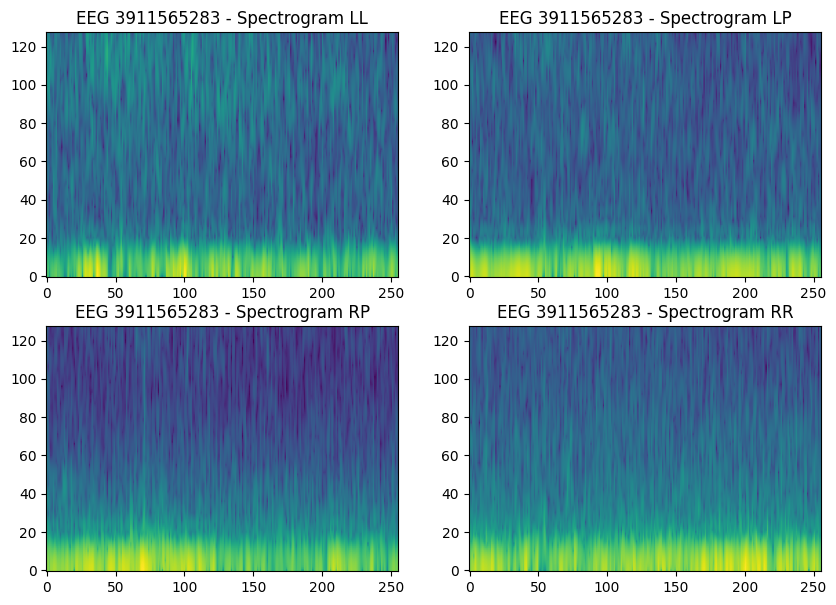

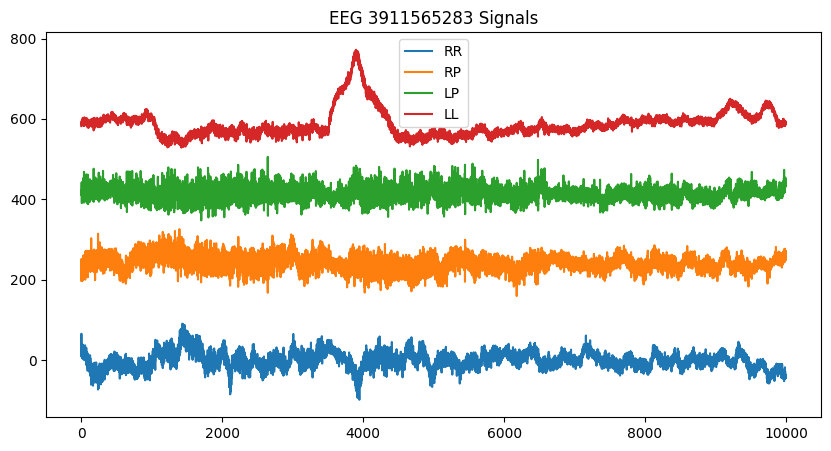


#########################

CPU times: user 15.1 s, sys: 675 ms, total: 15.8 s
Wall time: 16.5 s


In [19]:
%%time
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 4
EEG_IDS = test.eeg_id.unique()
all_eegs = {}

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='')
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')

    all_eegs[eeg_id] = img

for i, key in enumerate(all_eegs):
    layer0 = all_eegs[key][:,:,0]
    layer1 = all_eegs[key][:,:,1]
    layer2 = all_eegs[key][:,:,2]
    layer3 = all_eegs[key][:,:,3]
    
    all_eegs[key] = np.vstack([layer0, layer1, layer2, layer3])

In [20]:
test

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [21]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# The code generates features from the spectrogram data for use in a model 
# The features are derived by calculating the mean and minimum values over time for each of the 400 spectrogram frequencies.
# Two types of windows are used for these calculations:
# A 10-minute window (_mean_10m, _min_10m).
# A 20-second window (_mean_20s, _min_20s).
# This process results in 1600 features (400 features × 4 calculations) for each EEG ID.

TEST_FEATURES = [f'{c}_mean_50s' for c in range(SPEC_COLS)]
TEST_FEATURES += [f'{c}_mean_20s' for c in range(SPEC_COLS)]
print(f'We are creating {len(TEST_FEATURES)} features for {len(test)} rows... ',end='')


# A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# For each row in train, the code calculates the mean and minimum values within the specified 10-minute and 20-second windows.
# These calculated values are then stored in the data matrix.
# Finally, the matrix is added to the train DataFrame as new columns.

data = np.zeros((len(test),len(TEST_FEATURES)))
for k in range(len(test)):
    if k%100==0: print(k,', ',end='')
    row = test.iloc[k]  
        
    # 50 SECOND WINDOW FEATURES (MEANS) - Just 1 window in middle of spectogram
    x = np.nanmean(all_eegs[row.eeg_id], axis=1)
    data[k,:512] = x

    # 20 SECOND WINDOW FEATURES (MEANS and MINS) - Just 1 window in middle of spectogram
    # if 0-256 is 50s, then (77,179) is the central 20 second window.
    x = np.nanmean(all_eegs[row.eeg_id][:,77:179], axis=1)
    data[k,512:1024] = x 

    test[TEST_FEATURES] = data

    
print('New test shape:',test.shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
We are creating 1024 features for 1 rows... 0 , New test shape: (1, 1027)


In [22]:

# Columns to be excluded from scaling
excluded_columns = ['eeg_id', 'spectrogram_id', 'patient_id']

# Save the columns to be excluded
excluded_data = test[excluded_columns]

# DataFrame with only the columns to be scaled
features = test.drop(columns=excluded_columns)

# Fit the scaler to the features and transform them
features_scaled = train_scaler.transform(features)

# Create a DataFrame from the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Concatenate the scaled features with the excluded columns
test_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)
test_scaled_df 


,eeg_id,spectrogram_id,patient_id,0_mean_50s,1_mean_50s,2_mean_50s,3_mean_50s,4_mean_50s,5_mean_50s,6_mean_50s,...,502_mean_20s,503_mean_20s,504_mean_20s,505_mean_20s,506_mean_20s,507_mean_20s,508_mean_20s,509_mean_20s,510_mean_20s,511_mean_20s
0,3911565283,853520,6885,-0.758874,-0.74325,-0.732703,-0.727055,-0.726033,-0.729298,-0.737732,...,-0.476979,-0.463789,-0.438716,-0.408927,-0.386853,-0.370094,-0.36249,-0.361264,-0.35897,-0.343441


In [23]:
# INFER XGBOOST ON TEST
preds = []

for i in range(n_splits):
    print(i, ', ', end='')
    
    # Load the XGBoost model
    with open(f'XGBoost_f{i}.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Make predictions
    test_data_scaled = test_scaled_df[TEST_FEATURES]
    
    # data_imputed = imputer.fit_transform(test_data_scaled)
    
    pred = model.predict(test_data_scaled)
    pred[pred < 0] = 0
    pred = pred / np.sum(pred, axis=1).reshape(-1,1)
    preds.append(pred) 

# Average the predictions from each fold
pred = np.mean(preds, axis=0)
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , Test preds shape (1, 6)


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>12 |</span></b> <b>SUBMISSION</b></div>

In [24]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[LABEL_NAMES] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.187898,0.072286,0.021747,0.051722,0.098115,0.568232


In [25]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32